# Putting the R(etrieval) in RAG

In [20]:
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
import hashlib
import os
from datetime import datetime

from tqdm import tqdm

In [22]:
# Retrieve the Pinecone API key from user data
pinecone_key = os.environ.get('PINECONE_API_KEY')

# Initialize the OpenAI client with the API key from user data
client = OpenAI(
    api_key=os.environ.get('OPENAI_API_KEY')
)

# Define constants for the Pinecone index, namespace, and engine
ENGINE = 'text-embedding-3-small'  # The embedding model to use (vector size 1,536)

# Initialize the Pinecone client with the retrieved API key
pc = Pinecone(
    api_key=pinecone_key
)


In [23]:
INDEX_NAME = 'semantic-search-rag'  # The name of the Pinecone index
NAMESPACE = 'default'  # The namespace to use within the index

# Function to get embeddings for a list of texts using the OpenAI API
def get_embeddings(texts, engine=ENGINE):
    # Create embeddings for the input texts using the specified engine
    response = client.embeddings.create(
        input=texts,
        model=engine
    )

    # Extract and return the list of embeddings from the response
    return [d.embedding for d in list(response.data)]

# Function to get embedding for a single text using the OpenAI API
def get_embedding(text, engine=ENGINE):
    # Use the get_embeddings function to get the embedding for a single text
    return get_embeddings([text], engine)[0]

# Test the functions by getting the length of a single embedding and a list of embeddings
len(get_embedding('hi')), len(get_embeddings(['hi', 'hello']))

(1536, 2)

In [25]:
if INDEX_NAME not in pc.list_indexes().names():  # need to create the index
    print(f'Creating index {INDEX_NAME}')
    pc.create_index(
        name=INDEX_NAME,  # The name of the index
        dimension=1536,  # The dimensionality of the vectors for our OpenAI embedder
        metric='cosine',  # The similarity metric to use when searching the index
        spec=ServerlessSpec(
            cloud='aws',
            region='us-west-2'
        )
    )

# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

In [30]:
# index.delete(delete_all=True, namespace=NAMESPACE) # TO delete all vectors, be careful!

{}

In [32]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [33]:
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [34]:
def prepare_for_pinecone(texts, engine=ENGINE, urls=None):
    # Get the current UTC date and time
    now = datetime.utcnow()

    # Generate vector embeddings for each string in the input list, using the specified engine
    embeddings = get_embeddings(texts, engine=engine)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding vector embedding
    # The my_hash() function is used to generate a unique hash for each string, and the datetime.utcnow() function is used to generate the current UTC date and time
    responses = [
        (
            my_hash(text),  # A unique ID for each string, generated using the my_hash() function
            embedding,  # The vector embedding of the string
            dict(text=text, date_uploaded=now)  # A dictionary of metadata, including the original text and the current UTC date and time
        )
        for text, embedding in zip(texts, embeddings)  # Iterate over each input string and its corresponding vector embedding
    ]
    if urls and len(urls) == len(texts):
        for response, url in zip(responses, urls):
            response[-1]['url'] = url

    return responses


In [35]:
texts = ['hi']

In [36]:
_id, embedding, metadata = prepare_for_pinecone(texts)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': datetime.datetime(2024, 7, 24, 14, 43, 14, 172026)}


In [37]:
urls = ['fake.url']
_id, embedding, metadata = prepare_for_pinecone(texts, urls=urls)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': datetime.datetime(2024, 7, 24, 14, 43, 14, 614873), 'url': 'fake.url'}


In [38]:
def upload_texts_to_pinecone(texts, namespace=NAMESPACE, batch_size=None, show_progress_bar=False, urls=None):
    # Call the prepare_for_pinecone function to prepare the input texts for indexing
    total_upserted = 0
    if not batch_size:
        batch_size = len(texts)

    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        text_batch = texts[i: i + batch_size]
        if urls:
            url_batch = urls[i: i + batch_size]
            prepared_texts = prepare_for_pinecone(text_batch, urls=url_batch)
        else:
            prepared_texts = prepare_for_pinecone(text_batch)


        # Use the upsert() method of the index object to upload the prepared texts to Pinecone
        total_upserted += index.upsert(
            vectors=prepared_texts,
            namespace=namespace
        )['upserted_count']


    return total_upserted

In [40]:
# Call the upload_texts_to_pinecone() function with the input texts
upload_texts_to_pinecone(texts)

index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'default': {'vector_count': 1}},
 'total_vector_count': 1}

In [42]:
def query_from_pinecone(query, top_k=3, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

In [43]:
# test that the index is empty
query_from_pinecone('hello')

[{'id': '49f68a5c8493ec2c0bf489821c21fc3b',
  'metadata': {'date_uploaded': '2024-07-24T14:43:19.097262', 'text': 'hi'},
  'score': 0.80858922,
  'values': []}]

In [44]:
import hashlib

def delete_texts_from_pinecone(texts, namespace=NAMESPACE):
    # Compute the hash (id) for each text
    hashes = [hashlib.md5(text.encode()).hexdigest() for text in texts]

    # The ids parameter is used to specify the list of IDs (hashes) to delete
    return index.delete(ids=hashes, namespace=namespace)

# delete our text
delete_texts_from_pinecone(texts)


{}

In [45]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

# "Borrowing" Government Data

In [71]:
base_url = 'https://faq.ssa.gov'
medicare_faqs = base_url + '/en-US/topic?id=CAT-01092'
print(medicare_faqs)


https://faq.ssa.gov/en-US/topic?id=CAT-01092


In [64]:
def find_links_with_pattern(url, pattern):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Compile the regex pattern
    regex = re.compile(pattern)
    
    # Find all 'a' tags with href attribute matching the pattern
    links = soup.find_all('a', href=regex)
    
    # Extract and return the href values
    return [link.get('href') for link in links]

# Example usage
pattern = r'^/en-US'

matching_links = find_links_with_pattern(base_url, pattern)
len(matching_links)

19

In [67]:
urls = []

from bs4 import BeautifulSoup
import requests

for matching_link in tqdm(matching_links):
    r = requests.get(base_url + matching_link)
    soup = BeautifulSoup(r.content, 'html.parser')
    for link in soup.find_all('a'):
        if 'href' in link.attrs:
            if link['href'].startswith('/') and 'article' in link['href']:
                urls.append(base_url + link['href'])
    
urls = list(set([u.lower().strip() for u in urls]))
len(urls)

100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:30<00:00,  1.63s/it]


112

In [72]:
urls[0]

'https://faq.ssa.gov/en-us/topic/article/ka-03151'

In [68]:
import re

def clean_string(text):  # courtesy of Claude 3.5 Sonnet
    # Remove extra whitespace, including newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove any leading/trailing whitespace
    text = text.strip()
    # Remove common filler phrases
    filler_phrases = [
        "Skip to content", "Skip to main content", "Menu", "Sign in", "Print", "Views:", "Comments \(0\)",
        "Footer menu", "Give us Feedback.", "Did this answer your question?", "No Yes No", "Thanks for your feedback."
    ]
    for phrase in filler_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    # Remove any remaining brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    # Remove any remaining parentheses and their contents
    text = re.sub(r'\(.*?\)', '', text)
    # Remove any URLs
    text = re.sub(r'http\S+', '', text)
    # Remove any remaining special characters
    text = re.sub(r'[^\w\s\.\,\?\!]', '', text)
    # Remove extra spaces that may have been created
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [73]:
import requests

government_docs = []
for url in tqdm(urls):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    body = clean_string(soup.find('body').get_text())
    government_docs.append(dict(text=body, url=url))

100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]


In [74]:
government_docs[0]

{'text': 'Youre offline. This is a read only version of the page. Upcoming account changes Switch to Login.gov or ID.me for . Upcoming account changes Switch to Login.gov or ID.me for . Social Security Search Español Frequently Asked Questions FAQ Home Topics KA03151 Can I request a replacement card online if I am a naturalized citizen? Yes. If you are a naturalized citizen, you can request a replacement card online. However, Social Security must already have your citizenship verified and on file. Open a my Social Security account today. Footer ?',
 'url': 'https://faq.ssa.gov/en-us/topic/article/ka-03151'}

In [75]:
government_docs[-1]

{'text': 'Youre offline. This is a read only version of the page. Upcoming account changes Switch to Login.gov or ID.me for . Upcoming account changes Switch to Login.gov or ID.me for . Social Security Search Español Frequently Asked Questions FAQ Home Topics KA10045 What is the Disability Update Report and can I complete it online? The Disability Update Report is part of our Continuing Disability Review process, which is required by law. We periodically review your case to determine if you continue to meet the eligibility rules to receive disability benefits. We mail the Disability Update Report, or Form SSA455, to disabled beneficiaries to obtain updated information about their medical conditions and recent treatments. You also have the option to complete the SSA455 online. Keywords Online Services, SSI, SSDI, Disability Footer ?',
 'url': 'https://faq.ssa.gov/en-us/topic/article/ka-10045'}

In [78]:
BATCH_SIZE = 16
upload_texts_to_pinecone(
    texts=[g['text'] for g in government_docs],
    batch_size=BATCH_SIZE, show_progress_bar=True, 
    urls=[g['url'] for g in government_docs]
)

100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.32it/s]


112

In [89]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'default': {'vector_count': 112}},
 'total_vector_count': 112}

In [95]:
query = 'I lost my medicare card'

results = query_from_pinecone(query, top_k=3)
for result in results:
    print(result['metadata']['url'], result['score'], result['metadata']['text'][-50:])

https://faq.ssa.gov/en-us/topic/article/ka-01735 0.673578262  replacement card to be sent in the mail. Footer ?
https://faq.ssa.gov/en-us/topic/article/ka-02113 0.506656051 icare Medicaid Services Medicare Benefits Footer ?
https://faq.ssa.gov/en-us/topic/article/ka-02017 0.49886179 How do I get a replacement Medicare card? Footer ?


In [101]:
government_docs[0]

{'text': 'Youre offline. This is a read only version of the page. Upcoming account changes Switch to Login.gov or ID.me for . Upcoming account changes Switch to Login.gov or ID.me for . Social Security Search Español Frequently Asked Questions FAQ Home Topics KA03151 Can I request a replacement card online if I am a naturalized citizen? Yes. If you are a naturalized citizen, you can request a replacement card online. However, Social Security must already have your citizenship verified and on file. Open a my Social Security account today. Footer ?',
 'url': 'https://faq.ssa.gov/en-us/topic/article/ka-03151'}

# Synthetic Test Data Generation

In [662]:
synthetic_data_prompt = '''
I am designing a chatbot to use this document as information to our users.
Please write 10 questions that an average person not educated in this social security system might ask that can definitely be answered using information using the provided document.

Try to ask in a way that's confusing to really test our system's knowledge but still fair.

I need 5 in English, 2 in Spanish, 2 in Chinese, and 1 in French in that order.

Use this format to output:
Document: A given document to make questions from
JSON: ["english question 1", "english question 2", "english question 3", ...  "spanish question 1", "spanish question 2", ..., "french question 1"]
###
Document: {document}
JSON:'''

response = client.chat.completions.create(
    model='gpt-4',
    messages=[{"role": "user", "content": synthetic_data_prompt.format(document=government_docs[1]['text'])}],
    temperature=1
)

In [664]:
languages = ['english']*5+['spanish']*2+['chinese']*2 + ['french'] * 1

In [678]:
import json

list(zip(
    languages,
    json.loads('[' + response.choices[0].message.content.split('[')[-1].strip().split(']')[0].strip() + ']')
))

[('english',
  'How do I start the process for getting disability benefits from Social Security?'),
 ('english',
  "Can I apply for Social Security disability benefits if I don't live in the US?"),
 ('english',
  'What alternative ways are there to apply for Social Security disability benefits besides online?'),
 ('english',
  'What time can I call Social Security for disability application assistance?'),
 ('english',
  'Where can I find more information about disability benefits on the Social Security website?'),
 ('spanish', '¿Cómo solicito beneficios por discapacidad del Seguro Social?'),
 ('spanish',
  '¿Dónde debo acudir si no vivo en Estados Unidos pero quiero recibir beneficios del Seguro Social?'),
 ('chinese', '我不在美国居住，我可以申请社会保障残疾福利吗？'),
 ('chinese', '我要如何联系当地的社会保障办公室申请残疾福利？'),
 ('french',
  "Comment puis-je contacter mon bureau de sécurité sociale local pour des prestations d'invalidité?")]

In [704]:
synthetic_questions = []
from random import sample

# generate synthetic test data for a sample  of the urls found
SAMPLE = .2
for i, government_doc in enumerate(tqdm(sample(government_docs, int(len(government_docs) * SAMPLE)))):
        
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{"role": "user", "content": synthetic_data_prompt.format(document=government_doc['text'])}],
        temperature=1
    )
    try:
        questions = json.loads('[' + response.choices[0].message.content.split('[')[-1].strip().split(']')[0].strip() + ']')
        questions = [q.strip() for q in questions]
        assert len(questions) == len(languages)
        for language, question in zip(languages, questions):
            synthetic_questions.append(
            dict(
                language=language, 
                query=question, 
                expected_hash=my_hash(government_doc['text'])
            )
        )
    except Exception as e:
        print(f'Could not generate questions for index {i}: {e}')
    

100%|████████████████████████████████████████████████████████████████████████| 22/22 [01:27<00:00,  3.99s/it]


In [705]:
len(synthetic_questions)

220

In [706]:
synthetic_questions[0]

{'language': 'english',
 'query': "If I'm already getting Social Security benefits, do I need to sign up for Medicare?",
 'expected_hash': '3eff3f7809e71e9c0c7c6827769e4220'}

In [707]:
def test_query(query, expected_hash, language, top_k=10):
        
    results = query_from_pinecone(query, top_k=top_k)
    top_result_correct = results[0]['id'] == expected_hash
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)
    return dict(
        result_in_pinecone_list=result_in_pinecone_list, top_result_correct=top_result_correct,
        language=language, expected_hash=expected_hash, top_hash=results[0]['id']
    )

In [708]:
test_query(**synthetic_questions[0])

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'english',
 'expected_hash': '3eff3f7809e71e9c0c7c6827769e4220',
 'top_hash': '3eff3f7809e71e9c0c7c6827769e4220'}

In [709]:
synthetic_test_results = []
for synthetic_question in tqdm(synthetic_questions):
    synthetic_test_results.append(test_query(**synthetic_question))

100%|██████████████████████████████████████████████████████████████████████| 220/220 [01:02<00:00,  3.49it/s]


result_in_pinecone_list    0.981818
top_result_correct         0.836364
dtype: float64


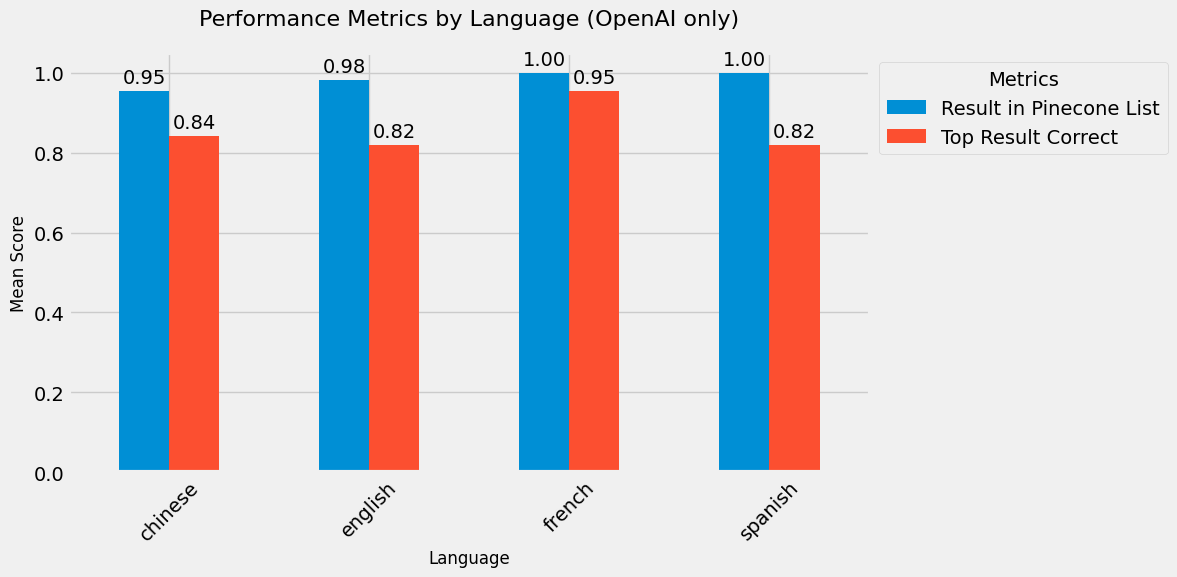

In [710]:
import pandas as pd
results_df = pd.DataFrame(synthetic_test_results)

print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

import matplotlib.pyplot as plt

# Assuming you've already created results_df
grouped_data = results_df.groupby('language')[['result_in_pinecone_list', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')
# sns.set_palette("deep")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI only)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(['Result in Pinecone List', 'Top Result Correct'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Making Retrieval Better with [Pongo](https://www.pongo.ai)


Pongo requires only a few lines extra of code to improve RAG performance.
Their filter uses a collection of auto-encoding models to improve search accuracy at runtime

In [711]:
import pongo

PONGO_KEY = os.environ.get('PONGO_KEY')

pongo_client = pongo.PongoClient(PONGO_KEY)

docs = [dict(text=result['metadata']['text'], metadata=dict(url=result['metadata']['url'])) for result in results]
    
filtered_result = pongo_client.filter(docs=docs, query=query, num_results=3)
filtered_docs = filtered_result.json()
top_doc = filtered_docs[0]
filtered_docs

[{'metadata': {'url': 'https://faq.ssa.gov/en-us/topic/article/ka-01735'},
  'score': 0.9158942699432373,
  'text': 'Youre offline. This is a read only version of the page. Upcoming account changes Switch to Login.gov or ID.me for . Upcoming account changes Switch to Login.gov or ID.me for . Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can an official copy of your card from your online Medicare account or call 1800MEDICARE to order a replacement card to be sent in the mail. Footer ?'},
 {'metadata': {'url': 'https://faq.ssa.gov/en-us/topic/article/ka-02017'},
  'score': 0.18379966914653778,
  'text': 'Youre offline. This is a read only version of the page. Upcoming account changes Switch to Login.gov or ID.me for . Upcoming account changes Switch to Login.gov or ID.me for . Social Security Search E

In [712]:
def test_query_with_pongo(query, expected_hash, language, top_k=10):
        
    results = query_from_pinecone(query, top_k=top_k)
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)    
    docs = [dict(text=result['metadata']['text'], metadata=dict(url=result['metadata']['url'])) for result in results]
        
    filtered_result = pongo_client.filter(docs=docs, query=query, num_results=1)
    filtered_docs = filtered_result.json()
    top_doc = filtered_docs[0]
    top_result_correct = my_hash(top_doc['text']) == expected_hash
    
    
    return dict(
        result_in_pinecone_list=result_in_pinecone_list, top_result_correct=top_result_correct,
        language=language, expected_hash=expected_hash, top_hash=results[0]['id']
    )

In [713]:
test_query_with_pongo(**synthetic_questions[0])

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'english',
 'expected_hash': '3eff3f7809e71e9c0c7c6827769e4220',
 'top_hash': '3eff3f7809e71e9c0c7c6827769e4220'}

In [714]:
synthetic_test_results_pongo = []
for synthetic_question in tqdm(synthetic_questions):
    synthetic_test_results_pongo.append(test_query_with_pongo(**synthetic_question))

100%|██████████████████████████████████████████████████████████████████████| 220/220 [02:43<00:00,  1.35it/s]


result_in_pinecone_list    0.981818
top_result_correct         0.895455
dtype: float64


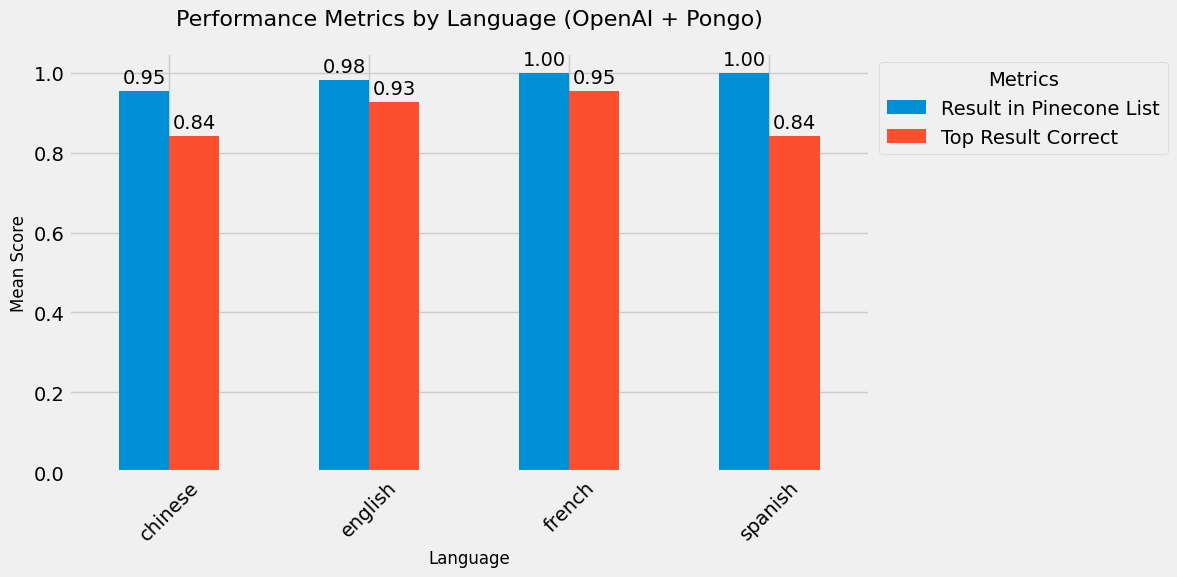

In [715]:
import pandas as pd
results_df = pd.DataFrame(synthetic_test_results_pongo)
print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())


grouped_data = results_df.groupby('language')[['result_in_pinecone_list', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI + Pongo)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(['Result in Pinecone List', 'Top Result Correct'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

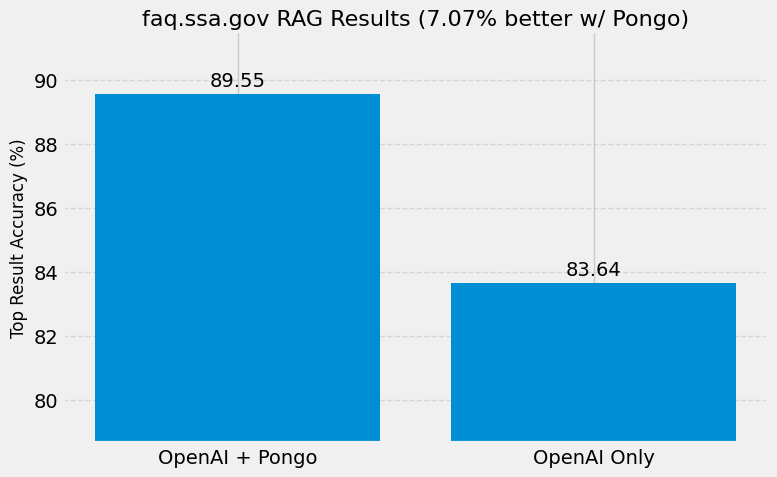

In [716]:
import matplotlib.pyplot as plt

# Data
data = {
    'OpenAI + Pongo': pd.Series([s['top_result_correct'] for s in synthetic_test_results_pongo]).mean() * 100,
    'OpenAI Only': pd.Series([s['top_result_correct'] for s in synthetic_test_results]).mean() * 100
}

percent_change = round((data['OpenAI + Pongo'] - data['OpenAI Only']) / data['OpenAI Only'] * 100, 2)

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))  # Reduced from (10, 6)

# Plot the data
bars = ax.bar(data.keys(), data.values())

# Customize the plot
ax.set_title(
    f'{base_url.split("//")[-1]} RAG Results ({percent_change}% {"better" if percent_change > 0 else "worse"} w/ Pongo)', 
    fontsize=16, pad=4)
ax.set_ylabel('Top Result Accuracy (%)', fontsize=12)
ax.tick_params(axis='x')

# Add value labels on top of each bar
ax.bar_label(bars, fmt='%.2f', padding=3)

# Adjust y-axis to start from 0.7 for better visualization of differences
ax.set_ylim(min(data.values()) - 5, max(data.values()) + 2)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

result_in_pinecone_list           0.981818
top_result_correct                0.895455
top_result_correct_openai_only    0.836364
dtype: float64


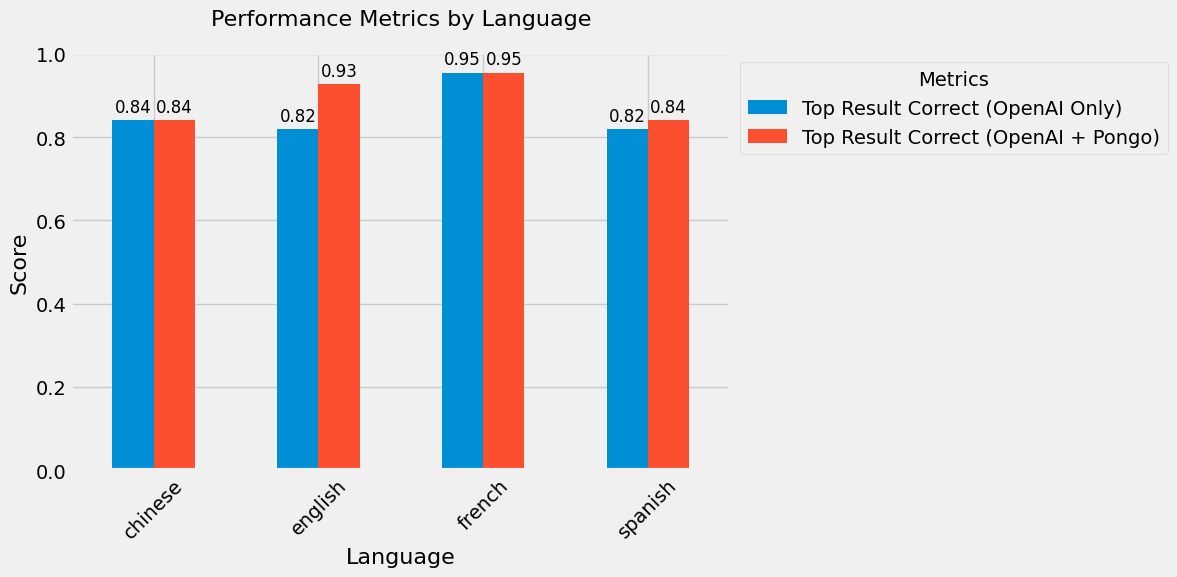

In [717]:
results_df = pd.DataFrame(synthetic_test_results_pongo)
results_df['top_result_correct_openai_only'] = [s['top_result_correct'] for s in synthetic_test_results]
print(results_df[['result_in_pinecone_list', 'top_result_correct', 'top_result_correct_openai_only']].mean())


grouped_data = results_df.groupby('language')[['top_result_correct_openai_only', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=16)
ax.set_ylabel('Score', fontsize=16)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3, fontsize=12)

# Add a legend
ax.legend(['Top Result Correct (OpenAI Only)', 'Top Result Correct (OpenAI + Pongo)'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Making Retrieval Better with [Cohere](cohere.com/rerank)


Similar to Pongo, "Rerank provides a powerful semantic boost to the search quality of any keyword or vector search system without requiring any overhaul or replacement."

In [718]:
import cohere

co = cohere.Client(os.environ.get('COHERE_API_KEY'))


In [719]:
docs = [
    "Carson City is the capital city of the American state of Nevada.",
    "The Commonwealth of the Northern Mariana Islands is a group of islands in the Pacific Ocean. Its capital is Saipan.",
    "Capitalization or capitalisation in English grammar is the use of a capital letter at the start of a word. English usage varies from capitalization in other languages.",
    "Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district.",
    "Capital punishment (the death penalty) has existed in the United States since beforethe United States was a country. As of 2017, capital punishment is legal in 30 of the 50 states.",
]

response = co.rerank(
    model="rerank-english-v3.0",
    query="What is the capital of the United States?",
    documents=docs,
    top_n=1,
)

docs[response.results[0].index]

'Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district.'

In [720]:
def test_query_with_cohere(query, expected_hash, language, top_k=10):
        
    results = query_from_pinecone(query, top_k=top_k)
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)    
    docs = [result['metadata']['text'] for result in results]
        
        
    response = co.rerank(
        model="rerank-multilingual-v3.0",
        query=query,
        documents=docs,
        top_n=1,
    )

    top_doc = docs[response.results[0].index]
    top_result_correct = my_hash(top_doc) == expected_hash
    
    return dict(
        result_in_pinecone_list=result_in_pinecone_list, top_result_correct=top_result_correct,
        language=language, expected_hash=expected_hash, top_hash=results[0]['id']
    )

In [721]:
test_query_with_cohere(**synthetic_questions[0])

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'english',
 'expected_hash': '3eff3f7809e71e9c0c7c6827769e4220',
 'top_hash': '3eff3f7809e71e9c0c7c6827769e4220'}

In [722]:
synthetic_test_results_cohere = []
for synthetic_question in tqdm(synthetic_questions):
    synthetic_test_results_cohere.append(test_query_with_cohere(**synthetic_question))

100%|██████████████████████████████████████████████████████████████████████| 220/220 [02:22<00:00,  1.55it/s]


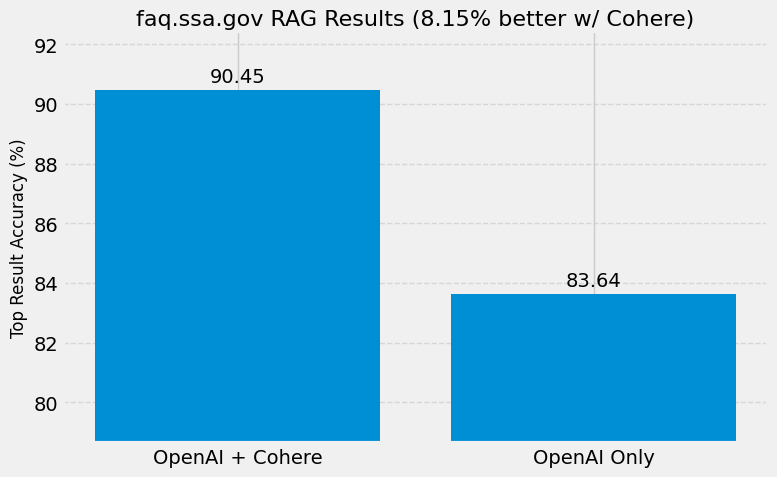

In [723]:
import matplotlib.pyplot as plt

# Data
data = {
    'OpenAI + Cohere': pd.Series([s['top_result_correct'] for s in synthetic_test_results_cohere]).mean() * 100,
    'OpenAI Only': pd.Series([s['top_result_correct'] for s in synthetic_test_results]).mean() * 100
}

percent_change = round((data['OpenAI + Cohere'] - data['OpenAI Only']) / data['OpenAI Only'] * 100, 2)

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))  # Reduced from (10, 6)

# Plot the data
bars = ax.bar(data.keys(), data.values())

# Customize the plot
ax.set_title(
    f'{base_url.split("//")[-1]} RAG Results ({percent_change}% {"better" if percent_change > 0 else "worse"} w/ Cohere)', 
    fontsize=16, pad=4)
ax.set_ylabel('Top Result Accuracy (%)', fontsize=12)
ax.tick_params(axis='x')

# Add value labels on top of each bar
ax.bar_label(bars, fmt='%.2f', padding=3)

# Adjust y-axis to start from 0.7 for better visualization of differences
ax.set_ylim(min(data.values()) - 5, max(data.values()) + 2)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

result_in_pinecone_list    0.981818
top_result_correct         0.904545
dtype: float64


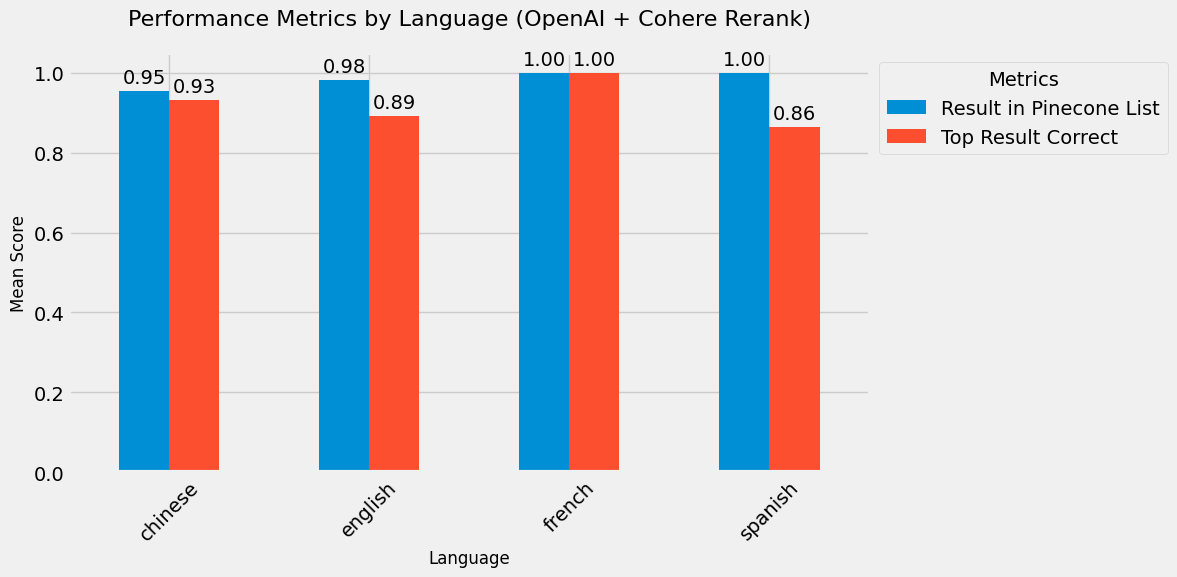

In [724]:
import pandas as pd
results_df = pd.DataFrame(synthetic_test_results_cohere)
print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

grouped_data = results_df.groupby('language')[['result_in_pinecone_list', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI + Cohere Rerank)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(['Result in Pinecone List', 'Top Result Correct'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Final Results

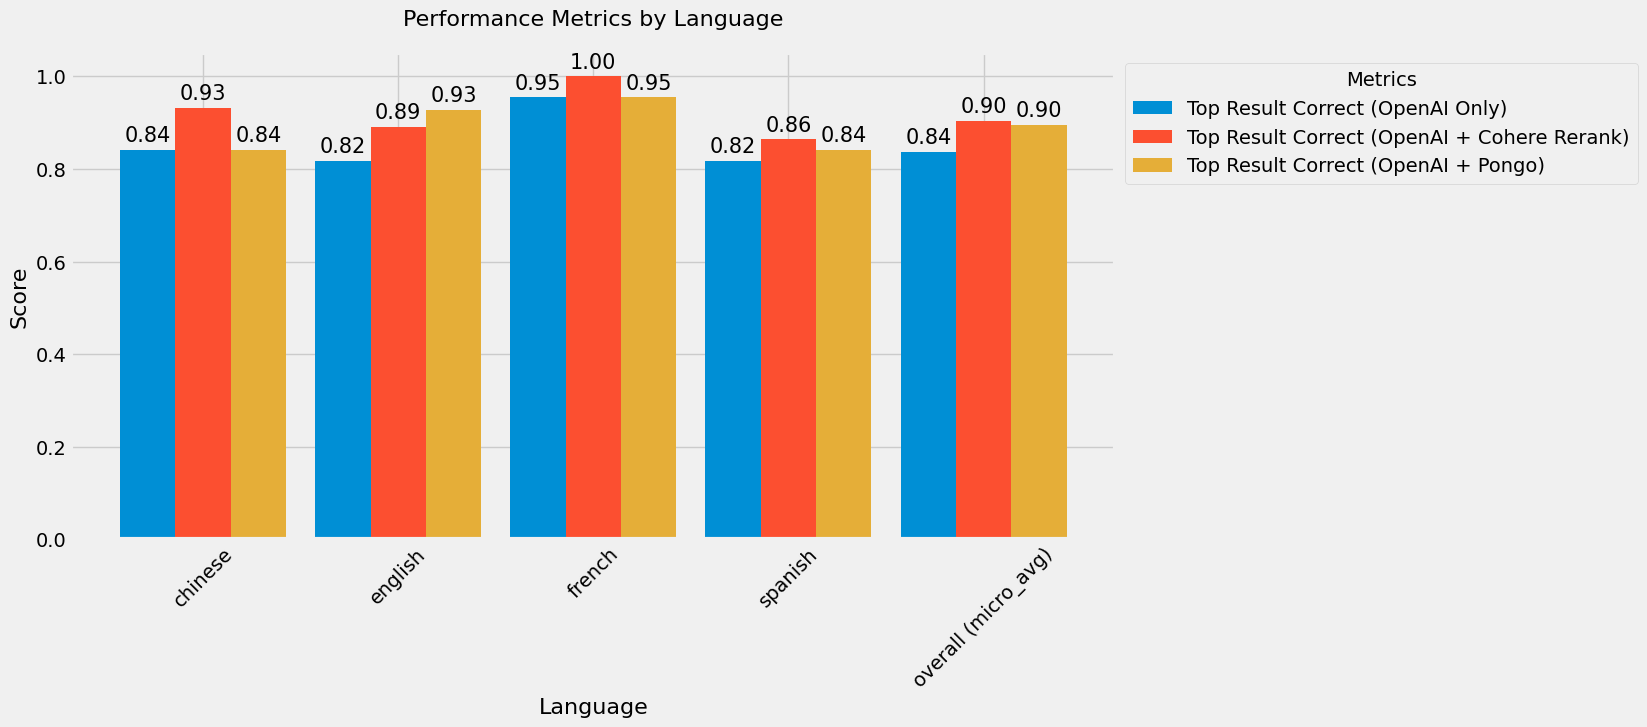

In [725]:
# Define the weights for each language
weights = {'english': 0.5, 'french': 0.1, 'spanish': 0.2, 'chinese': 0.2}

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

results_df = pd.DataFrame(synthetic_test_results_pongo)
results_df['top_result_correct_openai_only'] = [s['top_result_correct'] for s in synthetic_test_results]
results_df['top_result_correct_cohere'] = [s['top_result_correct'] for s in synthetic_test_results_cohere]

grouped_data = results_df.groupby('language')[['top_result_correct_openai_only', 'top_result_correct_cohere', 'top_result_correct']].mean().sort_index()

# Calculate the weighted overall score
weighted_overall = (grouped_data.mul(weights, axis=0).sum()) / sum(weights.values())
grouped_data.loc['overall (micro_avg)'] = weighted_overall

# Plot the data with wider bars
grouped_data.plot(kind='bar', ax=ax, width=0.85)

# Customize the plot
ax.set_title('Performance Metrics by Language', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=16)
ax.set_ylabel('Score', fontsize=16)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3, fontsize=15)

# Add a legend
ax.legend(['Top Result Correct (OpenAI Only)', 'Top Result Correct (OpenAI + Cohere Rerank)', 'Top Result Correct (OpenAI + Pongo)'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
# plt.tight_layout()
plt.show()
